In [25]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import matplotlib.colors as mcolors
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import HDBSCAN

# 设置路径
now_path = os.getcwd()
data_path=now_path+'\\..\\raw data\\'

# 读取数据函数
def extract_gene_name_from_index(index_str):
    """从索引字符串中提取基因名"""
    parts = index_str.split('_')
    if len(parts) >= 2:
        return parts[1]
    else:
        return index_str

# 读取数据
file1 = 'K562_essential_normalized_bulk_01.h5ad'
file2 = 'K562_gwps_normalized_bulk_01.h5ad'
file3 = 'rpe1_normalized_bulk_01.h5ad'

#K_e_n_b_adata=sc.read_h5ad(data_path+file1)
K_g_n_b_adata=sc.read_h5ad(data_path+file2)
#R_e_n_b_adata=sc.read_h5ad(data_path+file3)

# 添加target列
#K_e_n_b_adata.obs['target'] = [extract_gene_name_from_index(idx) for idx in K_e_n_b_adata.obs.index]
K_g_n_b_adata.obs['target'] = [extract_gene_name_from_index(idx) for idx in K_g_n_b_adata.obs.index]
#R_e_n_b_adata.obs['target'] = [extract_gene_name_from_index(idx) for idx in R_e_n_b_adata.obs.index]

#print(f"K562 essential: {K_e_n_b_adata.shape}")
print(f"K562 genome-wide: {K_g_n_b_adata.shape}")
#print(f"RPE1: {R_e_n_b_adata.shape}")


K562 genome-wide: (11258, 8248)


In [26]:
import torch


In [27]:
# 1. 全程 float32 + 不保留副本
torch.set_default_dtype(torch.float32)      # 让 pymde 也用 float32

# 2. 关掉 Jupyter 的自动大对象回传
os.environ["PYMDE_SUPPRESS_PLOTS"] = "1"
%config InlineBackend.figure_format = 'svg'

# 3. 单线程，防止 MKL/OPENBLAS 预分配
os.environ["OMP_NUM_THREADS"] = "1"
torch.set_num_threads(1)

In [28]:
# 步骤1: 筛选强扰动（按照论文标准）
mask = (K_g_n_b_adata.obs['anderson_darling_counts'] >= 50) & \
       (K_g_n_b_adata.obs['target'] != 'non-targeting') & \
       (K_g_n_b_adata.obs['num_cells_unfiltered'] >= 25) & \
       (K_g_n_b_adata.obs['pct_expr'] <= -0.3)

strong = K_g_n_b_adata[mask].copy()
print(f"强扰动数量: {strong.shape[0]}")

强扰动数量: 1948


In [ ]:
# 步骤2: 选择高变基因（前2319个，与论文一致）
# 计算变异系数
X_dense = strong.X.toarray() if hasattr(strong.X, 'toarray') else strong.X.copy()
means = np.mean(X_dense, axis=0)
stds = np.std(X_dense, axis=0)
eps = 1e-10
cv = stds / (means + eps)

# 选择前2319个高变基因
n_genes = min(8248, len(cv))
top_gene_indices = np.argsort(cv)[::-1][:n_genes]

# 提取高变基因表达矩阵
X_hvg = X_dense[:, top_gene_indices]
gene_names = [strong.var['gene_name'][i] for i in top_gene_indices]
target_names = strong.obs['target'].values

# 创建DataFrame
df = pd.DataFrame(X_hvg, index=target_names, columns=gene_names)
print(f"高变基因表达矩阵形状: {df.shape}")

高变基因表达矩阵形状: (1948, 8248)


In [30]:
df
# 1. 找出行列同名位置
same_mask = df.index.values[:, None] == df.columns.values[None, :]   # (n_row, n_col) 布尔阵

# 2. 原地赋 0
df.values[same_mask] = 0

In [ ]:
# 步骤3: 对扰动进行HDBSCAN聚类（64个簇）
# 计算扰动之间的相关性距离
print("计算扰动相关性...")
perturbation_corr = df.T.corr(method='pearson')
perturbation_distance = (2*(1 - perturbation_corr))**0.5
del perturbation_corr  # 释放内存

计算扰动相关性...


In [32]:
# 运行HDBSCAN聚类
print("运行HDBSCAN聚类扰动...")
clusterer_pert = HDBSCAN(
    min_cluster_size=4,
    min_samples=1,
    cluster_selection_method='eom',
    metric='precomputed'

)

运行HDBSCAN聚类扰动...


In [33]:
perturbation_labels = clusterer_pert.fit_predict(perturbation_distance)

# 分析聚类结果
unique_labels = np.unique(perturbation_labels)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(perturbation_labels == -1)

print(f"扰动聚类结果:")
print(f"  - 簇数量: {n_clusters}")
print(f"  - 噪声点: {n_noise}")
print(f"  - 总扰动数: {len(perturbation_labels)}")

扰动聚类结果:
  - 簇数量: 40
  - 噪声点: 1393
  - 总扰动数: 1948


In [34]:
import pymde

In [35]:
# 转置矩阵：基因在行，扰动在列（2319个基因 × 1973个扰动）
gene_expression_matrix = df.T.values  # 基因 × 扰动
print(f"基因表达矩阵形状: {gene_expression_matrix.shape}")

# 步骤1: 对每个基因的表达谱进行z-score归一化
# 论文方法: "we first z-normalized each expression profile"
print("对基因表达谱进行z-score归一化...")
from scipy.stats import zscore

# 按行（基因）进行z-score归一化
gene_expression_z = zscore(gene_expression_matrix, axis=1, ddof=1)

# 处理可能出现的NaN值（由于标准差为0）
gene_expression_z = np.nan_to_num(gene_expression_z, nan=0.0, posinf=0.0, neginf=0.0)
#释放内存，float32
gene_expression_z = gene_expression_z.astype('float32')

基因表达矩阵形状: (8248, 1948)
对基因表达谱进行z-score归一化...


In [36]:
print(f"Data shape: {gene_expression_z.shape}")
print(f"NaN count: {np.isnan(gene_expression_z).sum()}")
print(f"Inf count: {np.isinf(gene_expression_z).sum()}")
print(f"Data range: [{gene_expression_z.min():.2f}, {gene_expression_z.max():.2f}]")

Data shape: (8248, 1948)
NaN count: 0
Inf count: 0
Data range: [-10.91, 41.93]


In [37]:
import psutil
print(f"Available RAM: {psutil.virtual_memory().available / 1024**3:.2f} GB")

Available RAM: 12.46 GB


In [ ]:
import torch, pymde, numpy as np
import os
os.environ["PYMDE_SUPPRESS_PLOTS"] = "1"   # 禁止回传大图
torch.set_num_threads(1)                   # 防止 MKL 预分配

torch.set_default_dtype(torch.float32)

# 2. 20 维嵌入（论文步骤）
mde_20d = pymde.preserve_neighbors(
        torch.from_numpy(gene_expression_z),
        embedding_dim=20,
        n_neighbors=7,
        repulsive_fraction=5,
        init='random',          # 或先用 spectral 降维后再传入
        verbose=False,          # 必须关，否则 2319² 数字刷屏
        
)
X_mde_20d = mde_20d.embed(verbose=False)   # 返回 numpy float32
print("20D MDE shape:", X_mde_20d.shape)

Jan 08 08:18:35 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jan 08 08:18:35 PM: The following items have duplicates [0 1 2 3 4 5 6]
20D MDE shape: torch.Size([8248, 20])


In [46]:
# 步骤3: 在20维pyMDE嵌入空间进行HDBSCAN聚类
print("在20维pyMDE嵌入空间进行HDBSCAN聚类...")
clusterer_gene = HDBSCAN(
    min_cluster_size=10,
    min_samples=10,
    cluster_selection_method='leaf',
    metric='euclidean'
)

gene_labels = clusterer_gene.fit_predict(X_mde_20d)

# 分析聚类结果
unique_gene_labels = np.unique(gene_labels)
n_gene_clusters = len(unique_gene_labels[unique_gene_labels != -1])
n_gene_noise = np.sum(gene_labels == -1)

print(f"基因表达程序聚类结果:")
print(f"  - 簇数量: {n_gene_clusters}")
print(f"  - 噪声基因: {n_gene_noise}")
print(f"  - 总基因数: {len(gene_labels)}")


在20维pyMDE嵌入空间进行HDBSCAN聚类...
基因表达程序聚类结果:
  - 簇数量: 32
  - 噪声基因: 4352
  - 总基因数: 8248


Jan 08 08:23:37 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jan 08 08:23:37 PM: The following items have duplicates [0 1 2 3 4 5 6]


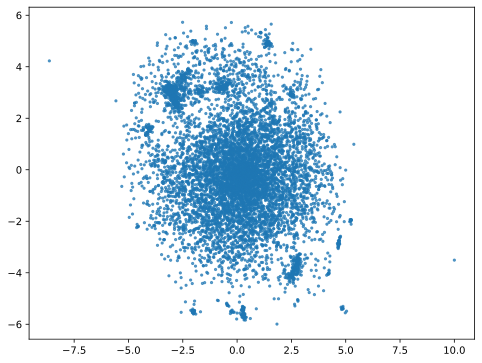

In [47]:
embedding_2d = pymde.preserve_neighbors(
    gene_expression_z,
    embedding_dim=2,
    n_neighbors=7,
    repulsive_fraction=5,
    init='random'
)
embedding_2d = embedding_2d.embed()


coords_2d=embedding_2d
# ---------------------------
# Step 3: 可视化
# ---------------------------
# 假设你有 cluster label
# cluster_labels = hdbscan_labels  # array of 1973 labels


plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    coords_2d[:,0],
    coords_2d[:,1],
    #c=labels,         # 用 cluster label 上色
    #cmap="tab20",
    #c="#004696",
    s=5,
    alpha=0.7
)
#plt.xlabel("MDE1")
#plt.ylabel("MDE2")

#plt.title("Figure 2D: 2D MDE embedding of perturbations")
plt.show()

In [42]:
# 步骤4: 可视化聚类结果
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# 子图1: 原始数据的t-SNE可视化
print("计算原始数据的t-SNE...")
from sklearn.manifold import TSNE
tsne_original = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_original = tsne_original.fit_transform(gene_expression_z)

ax1 = axes[0]
# 为每个基因簇分配颜色
cmap = plt.cm.tab20
colors = cmap(gene_labels % 20)
# 噪声基因用灰色
noise_mask = gene_labels == -1
colors[noise_mask] = [0.7, 0.7, 0.7, 1.0]

ax1.scatter(X_tsne_original[:, 0], X_tsne_original[:, 1], 
           c=colors, s=20, alpha=0.7, edgecolors='w', linewidth=0.5)
ax1.set_xlabel('t-SNE 1', fontsize=12)
ax1.set_ylabel('t-SNE 2', fontsize=12)
ax1.set_title(f'Original data (t-SNE)\n{n_gene_clusters} clusters, {n_gene_noise} noise genes', fontsize=14)
ax1.grid(True, alpha=0.3)

# 子图2: pyMDE 20维嵌入的t-SNE可视化
print("计算pyMDE嵌入的t-SNE...")
X_tsne_mde = tsne_original.fit_transform(X_mde_20d)

ax2 = axes[1]
ax2.scatter(X_tsne_mde[:, 0], X_tsne_mde[:, 1], 
           c=colors, s=20, alpha=0.7, edgecolors='w', linewidth=0.5)
ax2.set_xlabel('t-SNE 1', fontsize=12)
ax2.set_ylabel('t-SNE 2', fontsize=12)
ax2.set_title(f'pyMDE 20D embedding (t-SNE)\nEnhanced cluster separation', fontsize=14)
ax2.grid(True, alpha=0.3)

# 子图3: pyMDE 2维嵌入（用于可视化）
print("计算pyMDE 2维嵌入...")
# 按照论文方法，使用相同的参数但嵌入维度设置为2
mde_2d = pymde.preserve_neighbors(
    gene_expression_z,
    embedding_dim=2,
    n_neighbors=7,
    repulsive_fraction=5,
    init="random",  
    verbose=True
)

X_mde_2d = mde_2d.embed(verbose=True)

ax3 = axes[2]
scatter = ax3.scatter(X_mde_2d[:, 0], X_mde_2d[:, 1], 
                     c=colors, s=20, alpha=0.7, edgecolors='w', linewidth=0.5)
ax3.set_xlabel('MDE 1', fontsize=12)
ax3.set_ylabel('MDE 2', fontsize=12)
ax3.set_title(f'pyMDE 2D embedding (Figure 2D style)\n{n_gene_clusters} gene expression programs', fontsize=14)
ax3.grid(True, alpha=0.3)

# 添加图例
from matplotlib.patches import Patch
legend_elements = []
displayed_clusters = unique_gene_labels[unique_gene_labels != -1][:6]  # 只显示前6个非噪声簇
for label in displayed_clusters:
    legend_elements.append(
        Patch(facecolor=cmap(label % 20), label=f'Program {label}')
    )
if -1 in unique_gene_labels:
    legend_elements.append(Patch(facecolor=[0.7, 0.7, 0.7, 1.0], label='Noise genes'))

ax3.legend(handles=legend_elements, loc='upper right', fontsize=8)

plt.tight_layout()
#plt.savefig('../figures/gene_expression_programs_pymde_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print("基因表达程序聚类可视化已保存")

计算原始数据的t-SNE...
计算pyMDE嵌入的t-SNE...
计算pyMDE 2维嵌入...
Jan 08 08:21:57 PM: Computing 7-nearest neighbors, with max_distance=None
Jan 08 08:21:57 PM: Exact nearest neighbors by brute force 
Jan 08 08:22:00 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jan 08 08:22:00 PM: The following items have duplicates [0 1 2 3 4 5 6]
Jan 08 08:22:00 PM: Fitting a centered embedding into R^2, for a graph with 8248 items and 338232 edges.
Jan 08 08:22:00 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Jan 08 08:22:00 PM: iteration 000 | distortion 0.465663 | residual norm 0.0174576 | step length 30.3 | percent change 0.40796
Jan 08 08:22:03 PM: iteration 030 | distortion 0.321666 | residual norm 0.000663203 | step length 1 | percent change 0.296711
Jan 08 08:22:05 PM: iteration 060 | distortion 0.311892 | residual norm 0.000832379 | step length 1 | percent change 0.629844
Jan 08 08:22:08 PM: iteration 090 | di

基因表达程序聚类可视化已保存


In [48]:
# 步骤6: 只保留非噪声的扰动和基因
pert_indices_no_noise = perturbation_labels != -1
gene_indices_no_noise = gene_labels != -1

df_z=gene_expression_z.T  # 扰动 × 基因
df_df=pd.DataFrame(df_z)
df_clean = df_df.iloc[pert_indices_no_noise, gene_indices_no_noise]
clean_pert_labels = perturbation_labels[pert_indices_no_noise]
clean_gene_labels = gene_labels[gene_indices_no_noise]

# 步骤7: 计算每个扰动簇中每个基因表达程序的平均表达
unique_pert_clusters = np.unique(clean_pert_labels)
unique_gene_clusters = np.unique(clean_gene_labels)

print(f"非噪声扰动簇数: {len(unique_pert_clusters)}")
print(f"非噪声基因程序数: {len(unique_gene_clusters)}")


非噪声扰动簇数: 40
非噪声基因程序数: 32


In [49]:
# 初始化结果矩阵
program_scores = np.zeros((len(unique_pert_clusters), len(unique_gene_clusters)))

for i, pert_cluster in enumerate(unique_pert_clusters):
    # 获取属于该扰动簇的所有扰动
    pert_mask = clean_pert_labels == pert_cluster
    pert_data = df_clean.iloc[pert_mask, :]
    
    for j, gene_cluster in enumerate(unique_gene_clusters):
        # 获取属于该基因簇的所有基因
        gene_mask = clean_gene_labels == gene_cluster
        gene_data = pert_data.iloc[:, gene_mask]
        
        # 计算平均表达
        if gene_data.shape[1] > 0:
            program_scores[i, j] = gene_data.values.mean()

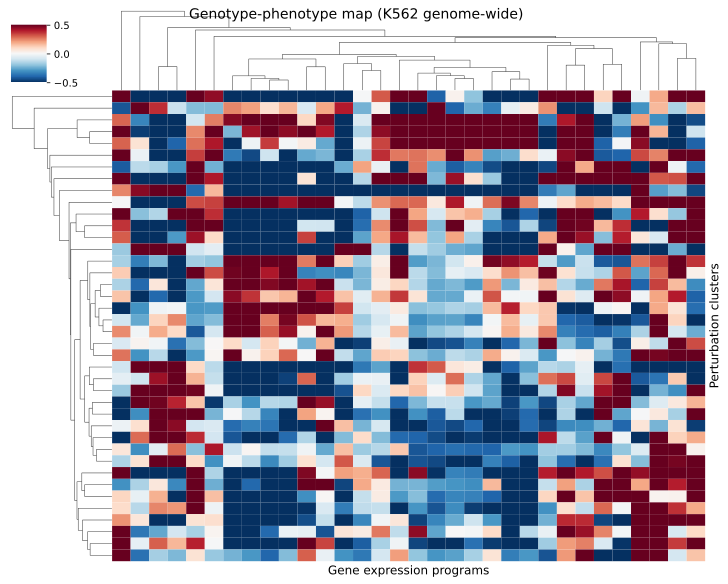

In [50]:
# 步骤8: 绘制热图（图4B）
g = sns.clustermap(
        program_scores,
        cmap='RdBu_r',
        vmin=-0.5, vmax=0.5,
        metric='euclidean',   # 行/列聚类用欧氏
        method='average',     # 层次平均链
        figsize=(10, 8),
        alpha=1,
        dendrogram_ratio=0.15,
        cbar_pos=(0.02, 0.85, 0.05, 0.1),  # 颜色条位置
        xticklabels=False, yticklabels=False,
        row_cluster=True, col_cluster=True
)

g.ax_heatmap.set_xlabel('Gene expression programs', fontsize=12)
g.ax_heatmap.set_ylabel('Perturbation clusters', fontsize=12)
g.fig.suptitle('Genotype-phenotype map (K562 genome-wide)', fontsize=14)

# 如需保存
#g.savefig('../figures/gene_expression_programs_clustermap.png', dpi=300, bbox_inches='tight')
plt.show()